In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import random
import pandas as pd
import multiprocessing as mp
import numpy as np
import osmnx as ox
import json
import networkx as nx
import pickle
from data_utils import *
import matplotlib

from scipy.stats import pearsonr, gamma, kstest, ks_2samp, wilcoxon
from scipy.stats import ttest_rel, ttest_ind
from scipy.stats import friedmanchisquare
from scipy.stats import shapiro
# import statsmodels.stats.contingency_tables.mcnemar
import matplotlib.pyplot as plt
import seaborn as sns
from acp import *

In [104]:
edges_all_prop = gpd.read_file("./output_data/analyse/edges_all_prop.gpkg")

In [105]:
edges_all_prop.columns

Index(['u', 'v', 'key', 'osmid', 'oneway', 'name', 'highway', 'maxspeed',
       'reversed', 'length', 'from', 'to', 'lanes', 'width', 'service',
       'access', 'bridge', 'ref', 'junction', 'tunnel', 'est_width', 'area',
       'uniqId', 'prairies_prop', 'ombres_08_prop', 'ombres_13_prop',
       'ombres_18_prop', 'arbustes_prop', 'arbres_prop', 'C_wavg_scaled',
       'eaux_prop', 'canop', 'geometry'],
      dtype='object')

In [8]:
def len_if_group(all_it_path):
    all_it = pd.read_csv(all_it_path)

    it_if = all_it[all_it["type"] == "IF"]
    it_len = all_it[all_it["type"] == "LEN"]
    
    return it_if, it_len

def ks_2samp_test(group1, group2, alternative):
    KS, p_value = ks_2samp(group1, group2, alternative=alternative)
    print("KS statistics : ", KS)
    print("p-value : ", p_value)
    return KS, p_value

def ks_2samp_test_key(key, column, alternative="two-sided", hour=False):
    path = ""
    if(hour):
        path = f"./output_data/analyse/{key}/{hour}/mean_value_by_it{key}.csv"
    else:
        path = f"./output_data/analyse/{key}/mean_value_by_it{key}.csv"
    dataset = pd.read_csv(path)

    it_if = dataset[dataset["type"] == "IF"][column]
    it_len = dataset[dataset["type"] == "LEN"][column]

    return ks_2samp_test(it_len, it_if, alternative=alternative)

def test_students(group1, group2, alternative="two-sided"):
    """In order to compare the mean between the distribution of group 1 and group 2"""
    return ttest_rel(group1, group2, alternative=alternative)

def test_students_key(key, column, hour=False, alternative="two-sided"):
    path = ""
    if(hour):
        path = f"./output_data/analyse/{key}/{hour}/mean_value_by_it{key}.csv"
    else:
        path = f"./output_data/analyse/{key}/mean_value_by_it{key}.csv"
    dataset = pd.read_csv(path)

    it_if = dataset[dataset["type"] == "IF"][column]
    it_len = dataset[dataset["type"] == "LEN"][column]

    return test_students(it_len, it_if, alternative=alternative)

def test_mcnemar(group1, group2):
    return 

def wilcoxon_test(group1, group2):
    return wilcoxon(group1, group2)

def wilcoxon_test_key(key, column, hour=False):
    path = ""
    if(hour):
        path = f"./output_data/analyse/{key}/{hour}/mean_value_by_it{key}.csv"
    else:
        path = f"./output_data/analyse/{key}/mean_value_by_it{key}.csv"
    dataset = pd.read_csv(path)

    it_if = dataset[dataset["type"] == "IF"][column]
    it_len = dataset[dataset["type"] == "LEN"][column]

    return wilcoxon_test(it_len, it_if)

def d_cohen(group1, group2):
    """In order to know if there is a size effect"""
    mean1 = np.mean(group1)
    mean2 = np.mean(group2)

    var1 = np.var(group1, ddof=1)
    var2 = np.var(group2, ddof=2)
    
    n1 = len(group1)
    n2 = len(group2)

    pooled_std = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))

    return (mean1 - mean2) / pooled_std

def d_cohen_key(key, column, hour=False):
    path = ""
    if(hour):
        path = f"./output_data/analyse/{key}/{hour}/mean_value_by_it{key}.csv"
    else:
        path = f"./output_data/analyse/{key}/mean_value_by_it{key}.csv"
    dataset = pd.read_csv(path)

    it_if = dataset[dataset["type"] == "IF"][column]
    it_len = dataset[dataset["type"] == "LEN"][column]

    return d_cohen(it_len, it_if)

def distance_cost(group1, group2):
    """Calculate the distance cost between itineraries"""
    d1 = np.array(group1["total_length"])
    d2 = np.array(group2["total_length"])

    percent_diff = ((d2-d1)/d1)*100

    return round(np.mean(percent_diff),2)

def select_most_frequent_index(frequency_data, quantile):
    limit_count = frequency_data["count"].quantile([quantile]).iloc[0]
    most_frequent = frequency_data[frequency_data["count"] >= limit_count]
    
    percent = (len(most_frequent)/len(frequency_data))*100
    
    print(f"percent most frequent :", percent)
    
    indexes_most_frequent = most_frequent.index.to_list()
    
    return indexes_most_frequent

def plot_data(data, name, max_y_value):
    # Calculate the common x-axis limits
    min_value = data.min()
    max_value = data.max()

    #Calculate the common y-axis limits
    min_y_value = 0
    max_y_value = max_y_value

    fig1 = plt.figure(figsize=(8, 6))
    plt.hist(data, bins=20, alpha=0.5, color="green")
    plt.xlabel(f"{name}")
    plt.ylabel("Frequency")
    plt.title(f"Histogram - {name}")
    plt.grid(True)
    plt.xlim(min_value, max_value)
    plt.ylim(min_y_value, max_y_value)

    mean = np.mean(data)
    var = np.var(data)
    std = np.std(data)
    quartiles = np.percentile(data, [25, 50, 75])
    sample_size = len(data)

    plt.axvline(mean, color='black', linestyle='dashed', linewidth=1)
    plt.axvline(quartiles[0], color='red', linestyle='dashed', linewidth=1)
    plt.axvline(quartiles[1], color='red', linestyle='solid', linewidth=1)
    plt.axvline(quartiles[2], color='red', linestyle='dashed', linewidth=1)

    plt.text(0.95, 0.95, f"Mean: {mean:.2f}\nVariance: {var:.2f}\nStd Deviation: {std:.2f}\n"
                         f"Q1: {quartiles[0]:.2f}\nQ2: {quartiles[1]:.2f}\nQ3: {quartiles[2]:.2f}\n"
                         f"Sample Size : {sample_size}",
             verticalalignment="top", horizontalalignment="right", transform=plt.gca().transAxes)

    plt.show()


def convert_score_on_ten(x, max):
    return (10/max)*x

def plot_distribution_by_category(dataframe, target_column, category_column, category_colors=None):
    """
    Plot the distribution of a target column colored by a category column.
    
    Parameters:
        dataframe (pd.DataFrame): The DataFrame containing the data.
        target_column (str): The column whose distribution will be plotted.
        category_column (str): The column used for coloring the distribution.
        category_colors (dict, optional): A dictionary specifying the colors for each category. 
                                          If not provided, default colors will be used.
    """
    if category_colors is None:
        category_colors = {}  # Default colors if not provided
        unique_categories = dataframe[category_column].unique()
        default_colors = plt.cm.tab10.colors
        for i, cat in enumerate(unique_categories):
            category_colors[cat] = default_colors[i % len(default_colors)]

    # Extract data for plotting
    data_to_plot = dataframe[[target_column, category_column]]

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot the histograms colored by category
    for cat, group in data_to_plot.groupby(category_column):
        ax1.hist(group[target_column], bins=10, alpha=0.6, color=category_colors[cat], label=cat)
        ax2.hist(group[target_column], bins=10, alpha=0.6, color=category_colors[cat], label=cat)

    # Calculate and display descriptive statistics
    descriptive_stats = dataframe.groupby(category_column)[target_column].describe()
    for cat in descriptive_stats.index:
        mean = descriptive_stats.loc[cat, 'mean']
        variance = descriptive_stats.loc[cat, 'std'] ** 2
        q25 = descriptive_stats.loc[cat, '25%']
        q50 = descriptive_stats.loc[cat, '50%']
        q75 = descriptive_stats.loc[cat, '75%']
        ax2.axvline(mean, color=category_colors[cat], linestyle='dashed', linewidth=1)
        ax2.axvline(q25, color=category_colors[cat], linestyle='dotted', linewidth=1)
        ax2.axvline(q50, color=category_colors[cat], linestyle='dotted', linewidth=1)
        ax2.axvline(q75, color=category_colors[cat], linestyle='dotted', linewidth=1)

    # Set plot properties
    ax1.set_xlabel(target_column)
    ax1.set_ylabel('Frequency')
    ax1.set_title(f'Distribution of {target_column} by {category_column}')
    ax1.legend()

    ax2.set_xlabel(target_column)
    ax2.set_title('Descriptive Statistics')
    ax2.grid(True)

    # Add a legend for descriptive statistics
    legend_elements = [plt.Line2D([0], [0], color=category_colors[cat], lw=1, label=cat) for cat in descriptive_stats.index]
    ax2.legend(handles=legend_elements, title=category_column)

    plt.tight_layout()
    plt.show()

def sns_plot(data, variable):
    sns.set(rc={'axes.facecolor':'#f4f2f2', 'figure.facecolor':'#f4f2f2'})
    colour_palette = {"IF": "blue", "LEN": "red"}
    legend = {"LEN": "Courts", "IF": "Frais"}
    sns.displot(data, x=variable, kind="kde", hue="type", fill=True, legend=False, palette=colour_palette)

    plt.ylabel("Densité")
    plt.xlabel("")

    plt.legend(title="Types d'itinéraires", labels=legend.values())
    plt.show()

def sns_plot_key(key, column, hour=False):
    path = ""
    if(hour):
        path = f"./output_data/analyse/{key}/{hour}/mean_value_by_it{key}.csv"
    else:
        path = f"./output_data/analyse/{key}/mean_value_by_it{key}.csv"
    dataset = pd.read_csv(path)

    sns_plot(dataset, column)

def basic_stats(data):
    return pd.DataFrame({
        "mean": np.mean(data),
        "var": np.var(data),
        "quantiles": np.quantile(data, q=[0.25,0.5,0.75])
    })

def basic_stats_key(key, column, hour=False, distinct_if_len=False):
    path = ""
    if(hour):
        path = f"./output_data/analyse/{key}/{hour}/mean_value_by_it{key}.csv"
    else:
        path = f"./output_data/analyse/{key}/mean_value_by_it{key}.csv"
    dataset = pd.read_csv(path)

    sns_plot(dataset, column)

    if(distinct_if_len):
        it_if = dataset[dataset["type"] == "IF"]
        it_len = dataset[dataset["type"] == "LEN"]

        return{
            "IF": basic_stats(it_if[column]),
            "LEN": basic_stats(it_len[column])
        }
    else:
        return(basic_stats(dataset[column]))
    
def basic_stats_temp_key(key, column, scaler, hour=False, distinct_if_len=False):
    path = ""
    if(hour):
        path = f"./output_data/analyse/{key}/{hour}/mean_value_by_it{key}.csv"
    else:
        path = f"./output_data/analyse/{key}/mean_value_by_it{key}.csv"
    dataset = pd.read_csv(path)

    dataset["real_temp"] = scaler.inverse_transform(dataset[[column]])

    # print(dataset["real_temp"])
    sns_plot(dataset, "real_temp")

    if(distinct_if_len):
        it_if = dataset[dataset["type"] == "IF"]
        it_len = dataset[dataset["type"] == "LEN"]

        return{
            "IF": basic_stats(it_if["real_temp"]),
            "LEN": basic_stats(it_len["real_temp"])
        }
    else:
        return(basic_stats(dataset[column]))

def compare_gain(it_if, it_len, printed=True, q=[0.25,0.5,0.75]):
    all_percent_diff = []
    for i, l in zip(it_if, it_len):
        percent = round(((i - l)/(l+0.000001))*100, 2)
        all_percent_diff.append(percent)
    
    if(printed):
        print("Gain quantiles : ", np.quantile(all_percent_diff, q=q))
        print("Gain mean : ", np.mean(all_percent_diff))
    return all_percent_diff

def print_quantiles_to_compare(key1, key2, column):
    dataset_1 = pd.read_csv(f"./output_data/analyse/{key1}/13h/mean_value_by_it{key1}.csv")
    if_it_1 = dataset_1[dataset_1["type"] == "IF"]

    dataset_2 = pd.read_csv(f"./output_data/analyse/{key2}/13h/mean_value_by_it{key2}.csv")
    if_it_2 = dataset_2[dataset_2["type"] == "IF"]

    print(f"{column}; {key1}", basic_stats(if_it_1[column]))
    print(f"{column}; {key2}", basic_stats(if_it_2[column]))

# def print_quantiles_to_compare_spec(key1, column):
#     dataset_1 = pd.read_csv(f"./output_data/analyse/{key1}/13h/mean_value_by_it{key1}.csv")
#     if_it_1 = dataset_1[dataset_1["type"] == "IF"]

#     print(f"{column}; {key1}", basic_stats(if_it_1[column]))
#     print(f"{column}; arbres : ", basic_stats(arbres_if))

def gain_compare_key(key, column, hour=False):
    path = ""
    if(hour):
        path = f"./output_data/analyse/{key}/{hour}/mean_value_by_it{key}.csv"
    else:
        path = f"./output_data/analyse/{key}/mean_value_by_it{key}.csv"
    dataset = pd.read_csv(path)
    # print(dataset.columns)
    if_it = dataset[dataset["type"] == "IF"]
    if_len = dataset[dataset["type"] == "LEN"]

    all_percent_diff = compare_gain(if_it[column], if_len[column])

    return all_percent_diff

## Arbres pondération initiale

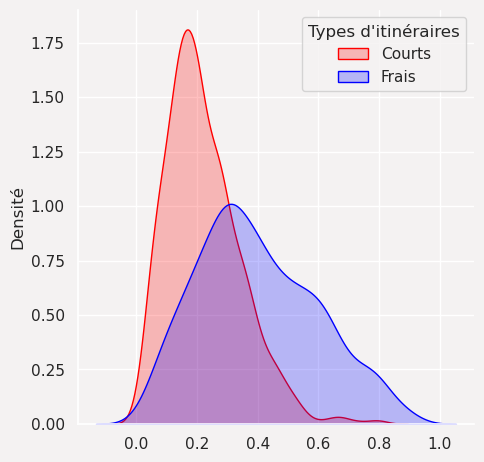

In [25]:
sns_plot_key("P0_01O0_01At0_01Ar10C0_01E0_01Ca0_01", "mean_arbres_prop", hour=False)

In [26]:
test_students_key("P0_01O0_01At0_01Ar10C0_01E0_01Ca0_01", "mean_arbres_prop")

TtestResult(statistic=-33.289557938606265, pvalue=4.833915109167011e-154, df=814)

In [28]:
gain_arbres = gain_compare_key("P0_01O0_01At0_01Ar10C0_01E0_01Ca0_01", "mean_arbres_prop")

Gain quantiles :  [ 19.175  72.    150.805]
Gain mean :  113.90090797546013


## Prise en compte de la variable ombre à 13H

### Analyse des gains

Gain en ombre avec la pondération initiale en arbres

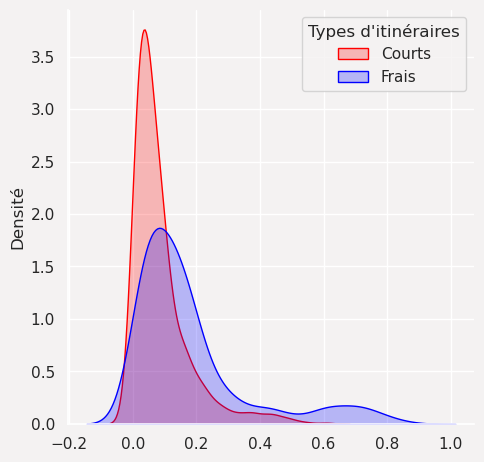

In [9]:
sns_plot_key("P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01", "mean_ombres_13_prop", hour="13h")

In [126]:
#comparaison des deux distributions : 
ks_2samp_test_key("P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01", "mean_ombres_13_prop", hour="13h")

KS statistics :  0.3165644171779141
p-value :  1.7218968015228244e-36


(0.3165644171779141, 1.7218968015228244e-36)

In [138]:
test_students_key("P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01", "mean_ombres_13_prop", hour="13h")

TtestResult(statistic=-20.88583421125668, pvalue=6.684541169192255e-78, df=814)

In [143]:
wilcoxon_test_key("P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01", "mean_ombres_13_prop", hour="13h")

WilcoxonResult(statistic=0.0, pvalue=5.811952142961751e-100)

In [128]:
d_cohen_key("P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01", "mean_ombres_13_prop", hour="13h")

-0.6396555163114584

In [146]:
gain_ombre_10_ar0 = gain_compare_key("P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01", "mean_ombres_13_prop", hour="13h")

Gain quantiles :  [  0.    66.66 216.66]
Gain mean :  249251.5120368098


In [147]:
gain_ombre_10_ar0 = gain_compare_key("P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01", "mean_arbres_prop", hour="13h")

Gain quantiles :  [-14.76   0.     0.  ]
Gain mean :  -3.025693251533743


In [149]:
ks_2samp_test_key("P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01", "mean_arbres_prop", hour="13h")

KS statistics :  0.06993865030674846
p-value :  0.03709891200718318


(0.06993865030674846, 0.03709891200718318)

In [151]:
d_cohen_key("P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01", "mean_arbres_prop", hour="13h")

0.14273044621724684

In [152]:
ks_2samp_test_key("P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01", "mean_ombres_13_prop", hour="13h")

KS statistics :  0.3165644171779141
p-value :  1.7218968015228244e-36


(0.3165644171779141, 1.7218968015228244e-36)

In [153]:
d_cohen_key("P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01", "mean_ombres_13_prop", hour="13h")

-0.6396555163114584

In [20]:
gain_ombres_ar10 = gain_compare_key("P0_01O0_01At0_01Ar10C0_01E0_01Ca0_01", "mean_ombres_13_prop", hour=False)

Gain quantiles :  [-33.33   0.     6.67]
Gain mean :  62580.23258895706


In [4]:
for w in range(9,0, -2):
    print("POID OMBRE : ", w)
    print("Arbres")
    ks_2samp_test_key(f"P0_01O{w}At0_01Ar10C0_01E0_01Ca0_01", "mean_arbres_prop")
    print("student : ", test_students_key(f"P0_01O{w}At0_01Ar10C0_01E0_01Ca0_01", "mean_arbres_prop"))
    # print("wilcoxon :", wilcoxon_test_key(f"P0_01O{w}At0_01Ar10C0_01E0_01Ca0_01", "mean_arbres_prop"))
    print("d cohen: ", d_cohen_key(f"P0_01O{w}At0_01Ar10C0_01E0_01Ca0_01", "mean_arbres_prop"))
    gain__arbres = gain_compare_key(f"P0_01O{w}At0_01Ar10C0_01E0_01Ca0_01", "mean_arbres_prop")
    # sns_plot_key(f"P0_01O{w}At0_01Ar10C0_01E0_01Ca0_01", "mean_arbres_prop")
    print("Ombres")
    gain__ombres = gain_compare_key(f"P0_01O{w}At0_01Ar10C0_01E0_01Ca0_01", "mean_ombres_13_prop")
    ks_2samp_test_key(f"P0_01O{w}At0_01Ar10C0_01E0_01Ca0_01", "mean_ombres_13_prop")
    print("student : ", test_students_key(f"P0_01O{w}At0_01Ar10C0_01E0_01Ca0_01", "mean_ombres_13_prop"))
    # print("wilcoxon :", wilcoxon_test_key(f"P0_01O{w}At0_01Ar10C0_01E0_01Ca0_01", "mean_ombres_13_prop"))
    print("d cohen: ", d_cohen_key(f"P0_01O{w}At0_01Ar10C0_01E0_01Ca0_01", "mean_ombres_13_prop"))
    # sns_plot_key(f"P0_01O{w}At0_01Ar10C0_01E0_01Ca0_01", "mean_ombres_13_prop")
    print("#### ####")

POID OMBRE :  9
Arbres
KS statistics :  0.23558282208588957
p-value :  3.045060720202295e-20
student :  TtestResult(statistic=-21.814892507652083, pvalue=1.9560026036812604e-83, df=814)
d cohen:  -0.5624237997883829
Gain quantiles :  [ 0.   18.52 61.11]
Gain mean :  51.66840490797546
Ombres
Gain quantiles :  [ 0.   8.2 75. ]
Gain mean :  73681.39646625768
KS statistics :  0.15337423312883436
p-value :  8.852057910679524e-09
student :  TtestResult(statistic=-15.601535559865992, pvalue=3.3197015877582293e-48, df=814)
d cohen:  -0.2930828261230545
#### ####
POID OMBRE :  7
Arbres
KS statistics :  0.25398773006134967
p-value :  1.699083743139277e-23
student :  TtestResult(statistic=-22.951718587164756, pvalue=2.741434315922277e-90, df=814)
d cohen:  -0.6353875878507645
Gain quantiles :  [ 0.    23.26  74.455]
Gain mean :  59.9123190184049
Ombres
Gain quantiles :  [ 0.     0.    61.505]
Gain mean :  72445.8133006135
KS statistics :  0.12515337423312883
p-value :  5.56984886240396e-06
studen

In [31]:
basic_stats_key("P0_01O10At0_01Ar0_01C0_01E0_01Ca0_01", "mean_ombres_13_prop", hour="13h", distinct_if_len=True)

{'IF':        mean       var  quantiles
 0  0.179975  0.034315       0.06
 1  0.179975  0.034315       0.12
 2  0.179975  0.034315       0.21,
 'LEN':        mean       var  quantiles
 0  0.086221  0.008556       0.03
 1  0.086221  0.008556       0.06
 2  0.086221  0.008556       0.11}

In [32]:
basic_stats_key("P0_01O5At0_01Ar10C0_01E0_01Ca0_01", "mean_ombres_13_prop", hour=False, distinct_if_len=True)

{'IF':        mean       var  quantiles
 0  0.102147  0.011456       0.03
 1  0.102147  0.011456       0.07
 2  0.102147  0.011456       0.12,
 'LEN':        mean       var  quantiles
 0  0.086221  0.008556       0.03
 1  0.086221  0.008556       0.06
 2  0.086221  0.008556       0.11}

In [33]:
basic_stats_key("P0_01O3At0_01Ar10C0_01E0_01Ca0_01", "mean_ombres_13_prop", hour=False, distinct_if_len=True)

{'IF':        mean       var  quantiles
 0  0.091546  0.009047       0.03
 1  0.091546  0.009047       0.06
 2  0.091546  0.009047       0.11,
 'LEN':        mean       var  quantiles
 0  0.086221  0.008556       0.03
 1  0.086221  0.008556       0.06
 2  0.086221  0.008556       0.11}

In [34]:
basic_stats_key("P0_01O5At0_01Ar10C0_01E0_01Ca0_01", "mean_arbres_prop", hour=False, distinct_if_len=True)

{'IF':       mean       var  quantiles
 0  0.32811  0.030696       0.20
 1  0.32811  0.030696       0.30
 2  0.32811  0.030696       0.44,
 'LEN':        mean       var  quantiles
 0  0.220245  0.014915       0.13
 1  0.220245  0.014915       0.20
 2  0.220245  0.014915       0.29}

In [35]:
basic_stats_key("P0_01O3At0_01Ar10C0_01E0_01Ca0_01", "mean_arbres_prop", hour=False, distinct_if_len=True)

{'IF':        mean       var  quantiles
 0  0.347939  0.033487       0.21
 1  0.347939  0.033487       0.32
 2  0.347939  0.033487       0.46,
 'LEN':        mean       var  quantiles
 0  0.220245  0.014915       0.13
 1  0.220245  0.014915       0.20
 2  0.220245  0.014915       0.29}

In [36]:
basic_stats_key("P0_01O0_01At0_01Ar10C0_01E0_01Ca0_01", "mean_arbres_prop", hour=False, distinct_if_len=True)

{'IF':        mean       var  quantiles
 0  0.398025  0.038378       0.25
 1  0.398025  0.038378       0.37
 2  0.398025  0.038378       0.54,
 'LEN':        mean       var  quantiles
 0  0.220245  0.014915       0.13
 1  0.220245  0.014915       0.20
 2  0.220245  0.014915       0.29}

In [163]:
gain_distance_ombre5arbre10 = gain_compare_key("P0_01O5At0_01Ar10C0_01E0_01Ca0_01", "total_length")
print(np.quantile(gain_distance_ombre5arbre10, q=[0.25,0.5,0.75,0.85,0.92,0.985]))

Gain quantiles :  [0.14 1.86 6.17]
Gain mean :  4.9839754601227
[ 0.14    1.86    6.17   10.955  17.2332 31.9173 44.71  ]


## Prise en compte de la variable ombre à 18h

### Analyse des gains

In [91]:
gain_ombres_ar10 = gain_compare_key("P0_01O0_01At0_01Ar10C0_01E0_01Ca0_01", "mean_ombres_18_prop", hour=False)

Gain quantiles :  [-20.39  -1.79   2.56]
Gain mean :  -5.074515337423312


In [7]:
for w in range(9,3, -2):
    print("POID OMBRE : ", w)
    print("Arbres")
    ks_2samp_test_key(f"P0_01O{w}At0_01Ar10C0_01E0_01Ca0_01", "mean_arbres_prop", hour="18h")
    print("student : ", test_students_key(f"P0_01O{w}At0_01Ar10C0_01E0_01Ca0_01", "mean_arbres_prop"))
    # print("wilcoxon :", wilcoxon_test_key(f"P0_01O{w}At0_01Ar10C0_01E0_01Ca0_01", "mean_arbres_prop"))
    print("d cohen: ", d_cohen_key(f"P0_01O{w}At0_01Ar10C0_01E0_01Ca0_01", "mean_arbres_prop", hour="18h"))
    gain__arbres = gain_compare_key(f"P0_01O{w}At0_01Ar10C0_01E0_01Ca0_01", "mean_arbres_prop", hour="18h")
    # sns_plot_key(f"P0_01O{w}At0_01Ar10C0_01E0_01Ca0_01", "mean_arbres_prop")
    print("Ombres")
    gain__ombres = gain_compare_key(f"P0_01O{w}At0_01Ar10C0_01E0_01Ca0_01", "mean_ombres_18_prop", hour="18h")
    ks_2samp_test_key(f"P0_01O{w}At0_01Ar10C0_01E0_01Ca0_01", "mean_ombres_18_prop", hour="18h")
    print("student : ", test_students_key(f"P0_01O{w}At0_01Ar10C0_01E0_01Ca0_01", "mean_ombres_13_prop"))
    # print("wilcoxon :", wilcoxon_test_key(f"P0_01O{w}At0_01Ar10C0_01E0_01Ca0_01", "mean_ombres_13_prop"))
    print("d cohen: ", d_cohen_key(f"P0_01O{w}At0_01Ar10C0_01E0_01Ca0_01", "mean_ombres_18_prop", hour="18h"))
    # sns_plot_key(f"P0_01O{w}At0_01Ar10C0_01E0_01Ca0_01", "mean_ombres_13_prop")
    print("#### ####")

POID OMBRE :  9
Arbres
KS statistics :  0.252760736196319
p-value :  2.8513359367624647e-23
student :  TtestResult(statistic=-21.814892507652083, pvalue=1.9560026036812604e-83, df=814)
d cohen:  -0.6357651483673669
Gain quantiles :  [ 0.    25.    82.285]
Gain mean :  62.86395092024541
Ombres
Gain quantiles :  [ 0.   11.11 34.55]
Gain mean :  30.099791411042947
KS statistics :  0.18404907975460122
p-value :  1.778937761529797e-12
student :  TtestResult(statistic=-15.601535559865992, pvalue=3.3197015877582293e-48, df=814)
d cohen:  -0.41424660448260864
#### ####
POID OMBRE :  7
Arbres
KS statistics :  0.2773006134969325
p-value :  5.5103779823593e-28
student :  TtestResult(statistic=-22.951718587164756, pvalue=2.741434315922277e-90, df=814)
d cohen:  -0.7101033107827966
Gain quantiles :  [ 0.    30.    92.585]
Gain mean :  70.09446625766871
Ombres
Gain quantiles :  [ 0.     7.58  28.015]
Gain mean :  24.240515337423307
KS statistics :  0.15460122699386503
p-value :  6.490881996141203e-0

In [ ]:
dataset_ombre_18 = gpd.read_file("./output_data/analyse/")

## Prise en compte de la température

Pour la température, les données ont été normalisées et standardisées entre 0 et 1 afin que la pondération ait un sens, cependant, pour l'analyse, nous observons la vrai valeur de température afin de donner plus de sens.

In [12]:
from sklearn.preprocessing import MinMaxScaler

In [11]:
temp_edges_path = "./output_data/network/edges/edges_buffered_temp_wavg_bounding_no_na.gpkg"

In [13]:
def calculate_mean_prop(it, score_column):
    """Calculate the mean proportion of one column for a given itinerary"""
    # print(score_column)
    # print(it[score_column])
    return round(sum(it[score_column]*it["length"])/sum(it["length"]), 2)

def get_real_temperature(key, temp_edges_path, hour="13h"):
    """Get the real temperature for the edges of one dataset through all edges prop file"""
    # edges_it = gpd.read_file(f"./output_data/analyse/{key}/{hour}/dataset_{key}.gpkg")
    edges_it = gpd.read_file("./output_data/analyse/P0_01O0_01At0_01Ar0_01C10E0_01Ca0_01/13h/dataset_P0_01O0_01At0_01Ar0_01C10E0_01Ca0_01.gpkg")
    print("edges_it ok")
    all_edges_prop = gpd.read_file(temp_edges_path)
    print("temp edges ok")

    edges_it = edges_it.set_index(["uniqId"])
    all_edges_prop = all_edges_prop.set_index(["uniqId"])

    all_edges_prop_sample = all_edges_prop.loc[edges_it.index.to_list()]

    edges_it["C"] =  all_edges_prop_sample["C"]

    return edges_it


In [14]:
temp_edges = gpd.read_file("./output_data/network/edges/edges_buffered_temp_wavg_bounding_no_na.gpkg")

In [15]:
temp_scaler = MinMaxScaler(feature_range=(0, 1))
temp_scaler.fit(temp_edges[["C_wavg"]])


MinMaxScaler()

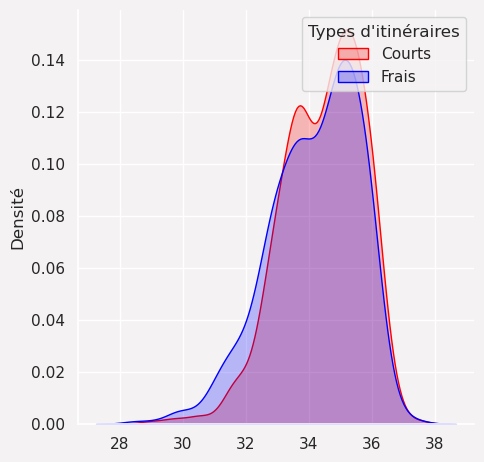

{'IF':         mean       var  quantiles
 0  34.175656  2.058617      33.30
 1  34.175656  2.058617      34.32
 2  34.175656  2.058617      35.34,
 'LEN':         mean       var  quantiles
 0  34.437018  1.619423      33.64
 1  34.437018  1.619423      34.66
 2  34.437018  1.619423      35.51}

In [16]:
basic_stats_temp_key("P0_01O0_01At0_01Ar0_01C10E0_01Ca0_01", "mean_C_wavg_scaled", temp_scaler, hour="13h", distinct_if_len=True)

In [47]:
basic_stats_key("P0_01O0_01At0_01Ar0_01C10E0_01Ca0_01", "mean_C_wavg_scaled", hour="13h", distinct_if_len=True)

{'IF':        mean       var  quantiles
 0  0.516209  0.005284      0.465
 1  0.516209  0.005284      0.520
 2  0.516209  0.005284      0.570,
 'LEN':        mean       var  quantiles
 0  0.496883  0.005604       0.45
 1  0.496883  0.005604       0.51
 2  0.496883  0.005604       0.56}

In [95]:
gain_temp_10 = gain_compare_key("P0_01O0_01At0_01Ar0_01C10E0_01Ca0_01", "mean_C_wavg_scaled", hour="13h")
print(np.quantile(gain_temp_10, q=[0.95]))

Gain quantiles :  [-3.42  0.    0.  ]
Gain mean :  -3.2225398773006133
[2.38]


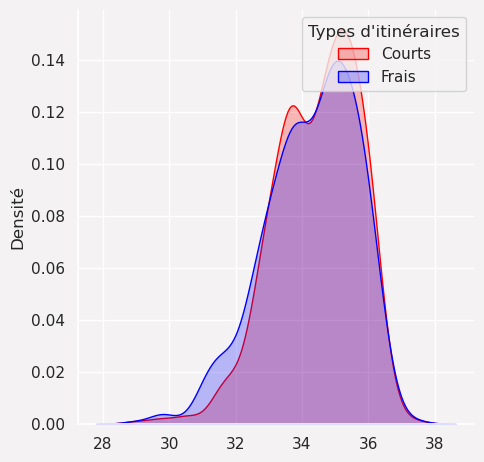

{'IF':         mean       var  quantiles
 0  34.263681  1.946993      33.30
 1  34.263681  1.946993      34.49
 2  34.263681  1.946993      35.34,
 'LEN':         mean       var  quantiles
 0  34.437018  1.619423      33.64
 1  34.437018  1.619423      34.66
 2  34.437018  1.619423      35.51}

In [17]:
basic_stats_temp_key("P0_01O5At0_01Ar10C1E0_01Ca0_01", "mean_C_wavg_scaled", temp_scaler, hour="13h", distinct_if_len=True)

In [100]:
gain_temp_10 = gain_compare_key("P0_01O5At0_01Ar10C1E0_01Ca0_01", "mean_C_wavg_scaled", hour="13h")
print(np.quantile(gain_temp_10, q=[0.95]))

Gain quantiles :  [-2.15  0.    0.  ]
Gain mean :  -2.0905153374233127
[4.76]


Essayons d'expliquer ce peu de différence entre les itinéraires les plus courts et les plus frais lorsque l'on prend en compte la température
Pour ce faire, regardons la distribution de la température sur la population des segments parcourus par les itinéraires

In [102]:
dataset_temp_10 = gpd.read_file("./output_data/analyse/P0_01O0_01At0_01Ar0_01C10E0_01Ca0_01/13h/dataset_P0_01O0_01At0_01Ar0_01C10E0_01Ca0_01.gpkg")

In [103]:
dataset_temp_10.columns

Index(['u', 'v', 'key', 'type', 'id_it', 'osmid', 'uniqId', 'length', 'from',
       'to', 'total_score_08', 'total_score_13', 'total_score_18',
       'freshness_score', 'score_distance_08', 'score_distance_13',
       'score_distance_18', 'zone_id', 'geometry'],
      dtype='object')

In [106]:
edges_all_prop = edges_all_prop.reset_index()
edges_all_prop = edges_all_prop.set_index(["uniqId"])
dataset_temp_10 = dataset_temp_10.reset_index()
dataset_temp_10 = dataset_temp_10.set_index(["uniqId"])

In [117]:
edges_all_prop_sample = edges_all_prop.loc[list(set(dataset_temp_10.index.to_list()))]
# edges_all_prop_sample["C_wavg_scaled"] = edges_all_prop_sample["C_wavg_scaled"]
edges_all_prop_sample["C_wavg"] = temp_scaler.inverse_transform(edges_all_prop_sample[["C_wavg_scaled"]])

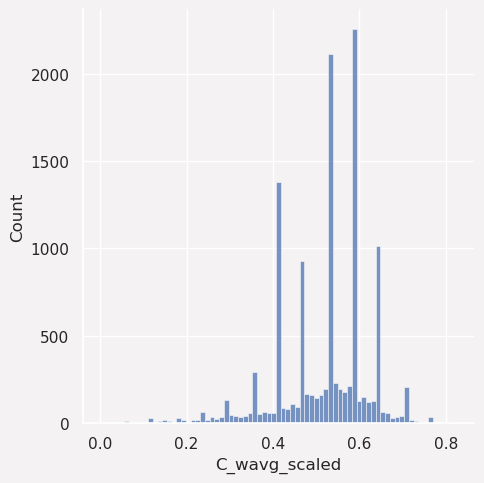

In [118]:
sns.displot(edges_all_prop_sample["C_wavg_scaled"])

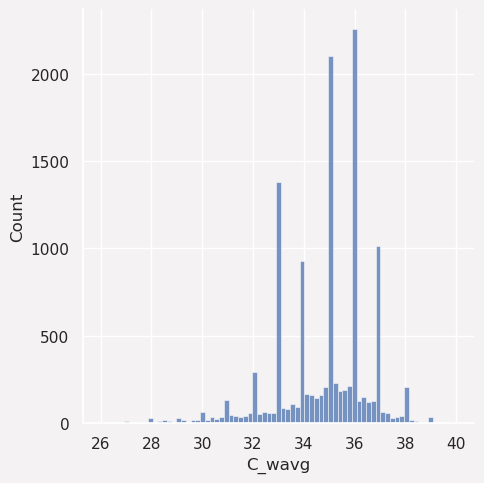

In [119]:
sns.displot(edges_all_prop_sample["C_wavg"])

In [121]:
np.quantile(edges_all_prop_sample["C_wavg"], q=[0.25,0.5,0.75])
basic_stats(edges_all_prop_sample["C_wavg"])

,mean,var,quantiles
0,34.790614,3.359219,33.84
1,34.790614,3.359219,35.00
2,34.790614,3.359219,36.00


In [122]:
basic_stats(edges_all_prop_sample["C_wavg_scaled"])

,mean,var,quantiles
0,0.517683,0.011624,0.461765
1,0.517683,0.011624,0.530000
2,0.517683,0.011624,0.588824


In [123]:
basic_stats(edges_all_prop["C_wavg_scaled"])

,mean,var,quantiles
0,0.545491,0.015011,0.471176
1,0.545491,0.015011,0.555882
2,0.545491,0.015011,0.628235


In [8]:
for w in range(9,0, -2):
    print("POID TEMPERATURE : ", w)
    print("Arbres")
    ks_2samp_test_key(f"P0_01O5At0_01Ar10C{w}E0_01Ca0_01", "mean_arbres_prop", hour="13h")
    print("student : ", test_students_key(f"P0_01O{w}At0_01Ar10C0_01E0_01Ca0_01", "mean_arbres_prop"))
    # print("wilcoxon :", wilcoxon_test_key(f"P0_01O{w}At0_01Ar10C0_01E0_01Ca0_01", "mean_arbres_prop"))
    print("d cohen: ", d_cohen_key(f"P0_01O5At0_01Ar10C{w}E0_01Ca0_01", "mean_arbres_prop", hour="13h"))
    gain__arbres = gain_compare_key(f"P0_01O5At0_01Ar10C{w}E0_01Ca0_01", "mean_arbres_prop", hour="13h")
    # sns_plot_key(f"P0_01O{w}At0_01Ar10C0_01E0_01Ca0_01", "mean_arbres_prop")
    print("TEMPERATURE")
    gain__ombres = gain_compare_key(f"P0_01O5At0_01Ar10C{w}E0_01Ca0_01", "mean_C_wavg_scaled", hour="13h")
    ks_2samp_test_key(f"P0_01O5At0_01Ar10C{w}E0_01Ca0_01", "mean_C_wavg_scaled", hour="13h")
    print("student : ", test_students_key(f"P0_01O{w}At0_01Ar10C0_01E0_01Ca0_01", "mean_C_wavg_scaled"))
    # print("wilcoxon :", wilcoxon_test_key(f"P0_01O{w}At0_01Ar10C0_01E0_01Ca0_01", "mean_ombres_13_prop"))
    print("d cohen: ", d_cohen_key(f"P0_01O5At0_01Ar10C{w}E0_01Ca0_01", "mean_C_wavg_scaled", hour="13h"))
    # sns_plot_key(f"P0_01O{w}At0_01Ar10C0_01E0_01Ca0_01", "mean_ombres_13_prop")
    print("#### ####")

POID TEMPERATURE :  9
Arbres
KS statistics :  0.24662576687116564
p-value :  3.6489331204078515e-22
student :  TtestResult(statistic=-21.814892507652083, pvalue=1.9560026036812604e-83, df=814)
d cohen:  -0.6253172094705967
Gain quantiles :  [ 0.    23.53  71.825]
Gain mean :  57.08174233128834
TEMPERATURE
Gain quantiles :  [-3.42  0.    0.  ]
Gain mean :  -3.2225398773006133
KS statistics :  0.07975460122699386
p-value :  0.011184542066222644
student :  TtestResult(statistic=5.942249780785607, pvalue=4.165584375065907e-09, df=814)
d cohen:  0.19254538224836984
#### ####
POID TEMPERATURE :  7
Arbres
KS statistics :  0.25766871165644173
p-value :  3.5389972351265164e-24
student :  TtestResult(statistic=-22.951718587164756, pvalue=2.741434315922277e-90, df=814)
d cohen:  -0.6461825754564051
Gain quantiles :  [ 0.   25.   76.09]
Gain mean :  59.34952147239264
TEMPERATURE
Gain quantiles :  [-3.33  0.    0.  ]
Gain mean :  -3.0752269938650305
KS statistics :  0.07730061349693251
p-value :  0

## Prise en compte de la variable Eau

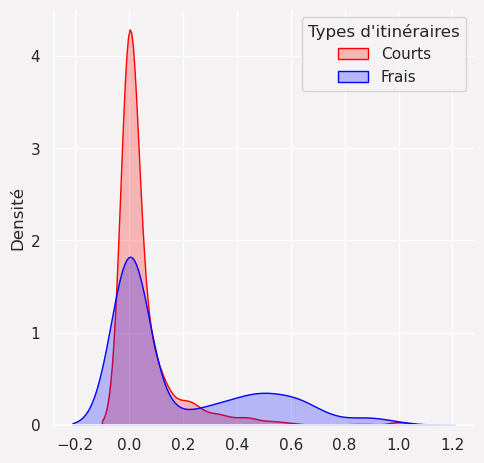

{'IF':        mean       var  quantiles
 0  0.180871  0.070939       0.00
 1  0.180871  0.070939       0.00
 2  0.180871  0.070939       0.39,
 'LEN':        mean       var  quantiles
 0  0.056061  0.016301       0.00
 1  0.056061  0.016301       0.00
 2  0.056061  0.016301       0.06}

In [18]:
basic_stats_key("P0_01O0_01At0_01Ar0_01C0_01E10Ca0_01", "mean_eaux_prop", hour="13h", distinct_if_len=True)

In [181]:
ks_2samp_test_key("P0_01O0_01At0_01Ar0_01C0_01E10Ca0_01", "mean_eaux_prop", hour="13h")

KS statistics :  0.252760736196319
p-value :  2.8513359367624647e-23


(0.252760736196319, 2.8513359367624647e-23)

In [182]:
d_cohen_key("P0_01O0_01At0_01Ar0_01C0_01E10Ca0_01", "mean_eaux_prop", hour="13h")

-0.596928645013175

L'eau (comme les parcs) est un cas particulier dans le sens où cette donnée n'est pas présente partout, elle n'est pas homogènement. 
Ainsi, il semblerait plutôt pertinent de regarder quels sont les itinéraires "frais" passant par l'eau et comparer seulement ceux-ci avec les itinéraires les plus courts correspondants.

In [192]:
def gain_water_key(key, hour=False):
    path = ""
    if(hour):
        path = f"./output_data/analyse/{key}/{hour}/mean_value_by_it{key}.csv"
    else:
        path = f"./output_data/analyse/{key}/mean_value_by_it{key}.csv"
    dataset = pd.read_csv(path)
    if_it = dataset[dataset["type"] == "IF"]
    if_it = if_it.set_index(["id_it"])
    if_len = dataset[dataset["type"] == "LEN"]
    if_len = if_len.set_index(["id_it"])

    print("IF eaux : ", np.quantile(if_it["mean_eaux_prop"], q=[0.25,0.5,0.75]))
    print("LEN eaux : ", np.quantile(if_len["mean_eaux_prop"], q=[0.25,0.5,0.75]))

    if_it_sample = if_it[if_it["mean_eaux_prop"] > 0]
    if_len_sample = if_len.loc[if_it_sample.index.to_list()]

    print("It avec eaux (%) :", (len(if_it_sample)/len(if_it))*100)

    print("IF eaux sample : ", np.quantile(if_it_sample["mean_eaux_prop"], q=[0.25,0.5,0.75]))
    print("LEN eaux sample : ", np.quantile(if_len_sample["mean_eaux_prop"], q=[0.25,0.5,0.75]))

    all_percent_diff = compare_gain(if_it_sample["mean_eaux_prop"], if_len_sample["mean_eaux_prop"])

    return all_percent_diff
    

In [168]:
gain_eaux = gain_compare_key("P0_01O0_01At0_01Ar0_01C0_01E10Ca0_01", "mean_eaux_prop", hour="13h")

Gain quantiles :  [  0.    0.  177.5]
Gain mean :  3049267.804834356


In [175]:
gain_eaux_sample = gain_water_key("P0_01O0_01At0_01Ar0_01C0_01E10Ca0_01", hour="13h")

IF eaux :  [0.   0.   0.39]
LEN eaux :  [0.   0.   0.06]
It avec eaux (%) : 44.04907975460123
IF eaux sample :  [0.205 0.44  0.6  ]
LEN eaux sample :  [0.01 0.07 0.16]
Gain quantiles :  [ 29.75 258.33 899.98]
Gain mean :  6922432.48172702


## Eau avec les arbres et l'ombre des bâtiments

### Ombre : 5, Arbres : 10, Eau : 9

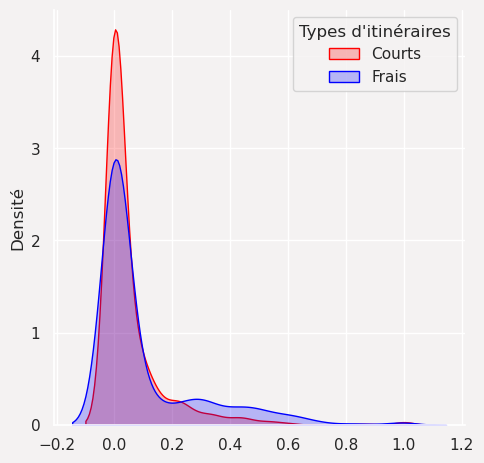

{'IF':        mean       var  quantiles
 0  0.099104  0.034514        0.0
 1  0.099104  0.034514        0.0
 2  0.099104  0.034514        0.1,
 'LEN':        mean       var  quantiles
 0  0.056061  0.016301       0.00
 1  0.056061  0.016301       0.00
 2  0.056061  0.016301       0.06}

In [19]:
basic_stats_key("P0_01O5At0_01Ar10C0_01E9Ca0_01", "mean_eaux_prop", hour="13h", distinct_if_len=True)

In [184]:
ks_2samp_test_key("P0_01O5At0_01Ar10C0_01E9Ca0_01", "mean_eaux_prop", hour="13h")

KS statistics :  0.11288343558282209
p-value :  6.0801963540346485e-05


(0.11288343558282209, 6.0801963540346485e-05)

In [185]:
d_cohen_key("P0_01O5At0_01Ar10C0_01E9Ca0_01", "mean_eaux_prop", hour="13h")

-0.2697576125973751

In [177]:
gain_eaux_sample_ar10_ombre5_eau9 = gain_water_key("P0_01O5At0_01Ar10C0_01E9Ca0_01", hour="13h")

IF eaux :  [0.  0.  0.1]
LEN eaux :  [0.   0.   0.06]
It avec eaux (%) : 39.38650306748466
IF eaux sample :  [0.06 0.21 0.4 ]
LEN eaux sample :  [0.04 0.08 0.2 ]
Gain quantiles :  [  0.     0.   199.98]
Gain mean :  2937842.0694392524


In [202]:
gain_eaux_ar10_ombre5_eau9 = gain_compare_key("P0_01O5At0_01Ar10C0_01E9Ca0_01", "mean_eaux_prop", hour="13h")
print(np.quantile(gain_eaux_ar10_ombre5_eau9, q=[0.85,0.9]))

Gain quantiles :  [0. 0. 0.]
Gain mean :  1157112.3979263804
[ 37.434 193.174]


In [178]:
gain_arbre_ar10_ombre5_eau9 = gain_compare_key("P0_01O5At0_01Ar10C0_01E9Ca0_01", "mean_arbres_prop", hour="13h")

Gain quantiles :  [ 0.    13.33  58.475]
Gain mean :  47.06851533742332


In [179]:
gain_ombre_ar10_ombre5_eau9 = gain_compare_key("P0_01O5At0_01Ar10C0_01E9Ca0_01", "mean_ombres_13_prop", hour="13h")

Gain quantiles :  [ 0.    0.   27.59]
Gain mean :  56469.95282208591


### Ombre : 5, Arbres : 10, Eau : 7

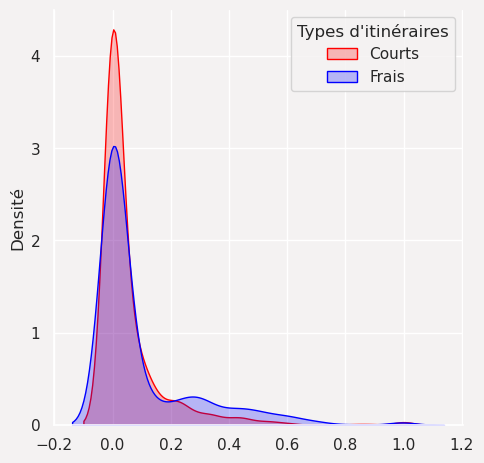

{'IF':        mean       var  quantiles
 0  0.093472  0.031371       0.00
 1  0.093472  0.031371       0.00
 2  0.093472  0.031371       0.09,
 'LEN':        mean       var  quantiles
 0  0.056061  0.016301       0.00
 1  0.056061  0.016301       0.00
 2  0.056061  0.016301       0.06}

In [20]:
basic_stats_key("P0_01O5At0_01Ar10C0_01E7Ca0_01", "mean_eaux_prop", hour="13h", distinct_if_len=True)

In [186]:
ks_2samp_test_key("P0_01O5At0_01Ar10C0_01E7Ca0_01", "mean_eaux_prop", hour="13h")

KS statistics :  0.10306748466257669
p-value :  0.0003441002104793967


(0.10306748466257669, 0.0003441002104793967)

In [187]:
d_cohen_key("P0_01O5At0_01Ar10C0_01E7Ca0_01", "mean_eaux_prop", hour="13h")

-0.24206914392940787

In [188]:
gain_eaux_sample_ar10_ombre5_eau7 = gain_water_key("P0_01O5At0_01Ar10C0_01E7Ca0_01", hour="13h")

IF eaux :  [0.   0.   0.09]
LEN eaux :  [0.   0.   0.06]
It avec eaux (%) : 39.14110429447853
IF eaux sample :  [0.06  0.2   0.365]
LEN eaux sample :  [0.045 0.08  0.2  ]
Gain quantiles :  [  0.     0.   137.43]
Gain mean :  2495424.2760815048


In [201]:
gain_eaux_ar10_ombre5_eau7 = gain_compare_key("P0_01O5At0_01Ar10C0_01E7Ca0_01", "mean_eaux_prop", hour="13h")
print(np.quantile(gain_eaux_ar10_ombre5_eau7, q=[0.85,0.9]))

Gain quantiles :  [0. 0. 0.]
Gain mean :  976735.7596196318
[ 23.908 128.908]


In [189]:
gain_arbre_ar10_ombre5_eau7 = gain_compare_key("P0_01O5At0_01Ar10C0_01E7Ca0_01", "mean_arbres_prop", hour="13h")

Gain quantiles :  [ 0.   17.65 61.11]
Gain mean :  50.45678527607362


In [190]:
gain_ombre_ar10_ombre5_eau7 = gain_compare_key("P0_01O5At0_01Ar10C0_01E7Ca0_01", "mean_ombres_13_prop", hour="13h")

Gain quantiles :  [ 0.     0.    29.705]
Gain mean :  57697.898159509205


### Ombre : 5, Arbres : 10, Eau : 5

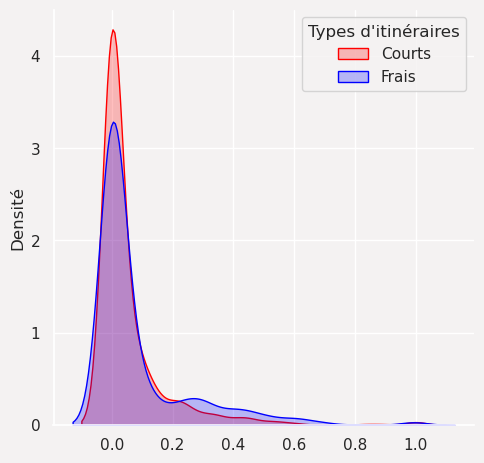

{'IF':        mean       var  quantiles
 0  0.082834  0.027005       0.00
 1  0.082834  0.027005       0.00
 2  0.082834  0.027005       0.08,
 'LEN':        mean       var  quantiles
 0  0.056061  0.016301       0.00
 1  0.056061  0.016301       0.00
 2  0.056061  0.016301       0.06}

In [21]:
basic_stats_key("P0_01O5At0_01Ar10C0_01E5Ca0_01", "mean_eaux_prop", hour="13h", distinct_if_len=True)

In [204]:
ks_2samp_test_key("P0_01O5At0_01Ar10C0_01E5Ca0_01", "mean_eaux_prop", hour="13h")

KS statistics :  0.0785276073619632
p-value :  0.013105720409177887


(0.0785276073619632, 0.013105720409177887)

In [205]:
d_cohen_key("P0_01O5At0_01Ar10C0_01E5Ca0_01", "mean_eaux_prop", hour="13h")

-0.1817622347517396

In [206]:
gain_eaux_sample_ar10_ombre5_eau5 = gain_water_key("P0_01O5At0_01Ar10C0_01E5Ca0_01", hour="13h")

IF eaux :  [0.   0.   0.08]
LEN eaux :  [0.   0.   0.06]
It avec eaux (%) : 39.018404907975466
IF eaux sample :  [0.05 0.13 0.32]
LEN eaux sample :  [0.0425 0.08   0.2   ]
Gain quantiles :  [ 0.      0.     53.4125]
Gain mean :  2254796.281006289


In [240]:
gain_eaux_ar10_ombre5_eau5 = gain_compare_key("P0_01O5At0_01Ar10C0_01E5Ca0_01", "mean_eaux_prop", hour="13h")
print(np.quantile(gain_eaux_ar10_ombre5_eau5, q=[0.85,0.9]))

Gain quantiles :  [0. 0. 0.]
Gain mean :  879784.4385030675
[ 0.   48.18]


In [4]:
gain_arbre_ar10_ombre5_eau5 = gain_compare_key("P0_01O5At0_01Ar10C0_01E5Ca0_01", "mean_arbres_prop", hour="13h")
print(np.quantile(gain_arbre_ar10_ombre5_eau5, q=[0.9]))

Gain quantiles :  [ 0.   20.   64.29]
Gain mean :  52.82462576687117
[139.236]


In [5]:
gain_ombre_ar10_ombre5_eau5 = gain_compare_key("P0_01O5At0_01Ar10C0_01E5Ca0_01", "mean_ombres_13_prop", hour="13h")
print(np.quantile(gain_ombre_ar10_ombre5_eau5, q=[0.9]))

Gain quantiles :  [ 0.    0.   33.33]
Gain mean :  54019.963349693266
[129.998]


In [242]:
gain_distance_ombre5arbre10eaux5 = gain_compare_key("P0_01O5At0_01Ar10C0_01E5Ca0_01", "total_length", hour="13h")
print(np.quantile(gain_distance_ombre5arbre10eaux5, q=[0.25,0.5,0.75,0.85,0.92,0.985]))

Gain quantiles :  [0.    0.77  3.685]
Gain mean :  3.073766871165644
[ 0.      0.77    3.685   6.806   9.9088 20.3981]


### Ombre : 5, Arbres : 10, Eau : 3

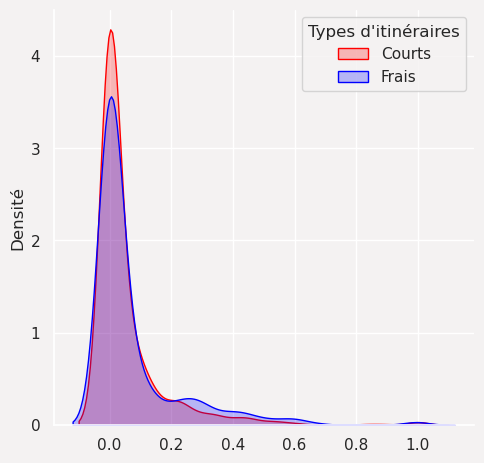

{'IF':        mean      var  quantiles
 0  0.073975  0.02326       0.00
 1  0.073975  0.02326       0.00
 2  0.073975  0.02326       0.07,
 'LEN':        mean       var  quantiles
 0  0.056061  0.016301       0.00
 1  0.056061  0.016301       0.00
 2  0.056061  0.016301       0.06}

In [22]:
basic_stats_key("P0_01O5At0_01Ar10C0_01E3Ca0_01", "mean_eaux_prop", hour="13h", distinct_if_len=True)

In [211]:
ks_2samp_test_key("P0_01O5At0_01Ar10C0_01E3Ca0_01", "mean_eaux_prop", hour="13h")

KS statistics :  0.05766871165644172
p-value :  0.1329993862236753


(0.05766871165644172, 0.1329993862236753)

In [212]:
d_cohen_key("P0_01O5At0_01Ar10C0_01E3Ca0_01", "mean_eaux_prop", hour="13h")

-0.12724907607831556

In [213]:
gain_eaux_sample_ar10_ombre5_eau3 = gain_water_key("P0_01O5At0_01Ar10C0_01E3Ca0_01", hour="13h")

IF eaux :  [0.   0.   0.07]
LEN eaux :  [0.   0.   0.06]
It avec eaux (%) : 38.40490797546012
IF eaux sample :  [0.05 0.12 0.28]
LEN eaux sample :  [0.05 0.08 0.21]
Gain quantiles :  [ 0.    0.   41.18]
Gain mean :  1313158.3514696485


In [215]:
gain_eaux_ar10_ombre5_eau3 = gain_compare_key("P0_01O5At0_01Ar10C0_01E3Ca0_01", "mean_eaux_prop", hour="13h")
print(np.quantile(gain_eaux_ar10_ombre5_eau3, q=[0.85,0.9]))

Gain quantiles :  [0. 0. 0.]
Gain mean :  504315.7841226994
[ 0.    35.728]


In [216]:
gain_arbre_ar10_ombre5_eau3 = gain_compare_key("P0_01O5At0_01Ar10C0_01E3Ca0_01", "mean_arbres_prop", hour="13h")

Gain quantiles :  [ 0.    25.    77.525]
Gain mean :  60.20434355828221


In [217]:
gain_ombre_ar10_ombre5_eau3 = gain_compare_key("P0_01O5At0_01Ar10C0_01E3Ca0_01", "mean_ombres_13_prop", hour="13h")

Gain quantiles :  [ 0.  0. 40.]
Gain mean :  61384.844453987724


## Arbustes 

### Arbustes 10, reste 0.01

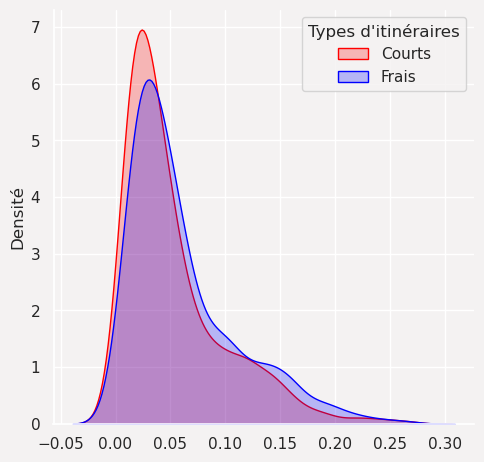

{'IF':        mean       var  quantiles
 0  0.061153  0.002476       0.03
 1  0.061153  0.002476       0.04
 2  0.061153  0.002476       0.08,
 'LEN':        mean       var  quantiles
 0  0.052515  0.002156       0.02
 1  0.052515  0.002156       0.04
 2  0.052515  0.002156       0.07}

In [23]:
basic_stats_key("P0_01O0_01At0_01Ar0_01C0_01E0_01Ca0_01", "mean_arbustes_prop", hour="13h", distinct_if_len=True)

In [219]:
ks_2samp_test_key("P0_01O0_01At0_01Ar0_01C0_01E0_01Ca0_01", "mean_arbustes_prop", hour="13h")

KS statistics :  0.09693251533742331
p-value :  0.0009379251590946946


(0.09693251533742331, 0.0009379251590946946)

In [220]:
d_cohen_key("P0_01O0_01At0_01Ar0_01C0_01E0_01Ca0_01", "mean_arbustes_prop", hour="13h")

-0.17930942997670749

In [221]:
gain_arbustes = gain_compare_key("P0_01O0_01At0_01Ar0_01C0_01E0_01Ca0_01", "mean_arbustes_prop", hour="13h")

Gain quantiles :  [ 0.    0.   33.33]
Gain mean :  8617.312368098159


In [224]:
for w in range(9,0, -2):
    print("POID ARBUSTES : ", w)
    print("Arbres")
    ks_2samp_test_key(f"P0_01O5At{w}Ar10C0_01E5Ca0_01", "mean_arbres_prop", hour="13h")
    # print("student : ", test_students_key(f"P0_01O{w}At0_01Ar10C0_01E0_01Ca0_01", "mean_arbres_prop"))
    # print("wilcoxon :", wilcoxon_test_key(f"P0_01O{w}At0_01Ar10C0_01E0_01Ca0_01", "mean_arbres_prop"))
    print("d cohen: ", d_cohen_key(f"P0_01O5At{w}Ar10C0_01E5Ca0_01", "mean_arbres_prop", hour="13h"))
    gain__arbres = gain_compare_key(f"P0_01O5At{w}Ar10C0_01E5Ca0_01", "mean_arbres_prop", hour="13h")
    # sns_plot_key(f"P0_01O{w}At0_01Ar10C0_01E0_01Ca0_01", "mean_arbres_prop")
    print("ARBUSTES")
    gain__ombres = gain_compare_key(f"P0_01O5At{w}Ar10C0_01E5Ca0_01", "mean_arbustes_prop", hour="13h")
    ks_2samp_test_key(f"P0_01O5At{w}Ar10C0_01E5Ca0_01", "mean_arbustes_prop", hour="13h")
    # print("student : ", test_students_key(f"P0_01O{w}At0_01Ar10C0_01E0_01Ca0_01", "mean_ombres_13_prop"))
    # print("wilcoxon :", wilcoxon_test_key(f"P0_01O{w}At0_01Ar10C0_01E0_01Ca0_01", "mean_ombres_13_prop"))
    print("d cohen: ", d_cohen_key(f"P0_01O5At{w}Ar10C0_01E5Ca0_01", "mean_arbustes_prop", hour="13h"))
    # sns_plot_key(f"P0_01O{w}At0_01Ar10C0_01E0_01Ca0_01", "mean_ombres_13_prop")
    print("#### ####")

POID ARBUSTES :  9
Arbres
KS statistics :  0.19631901840490798
p-value :  3.792377243339718e-14
d cohen:  -0.44809356385320764
Gain quantiles :  [ 0.     8.7   44.915]
Gain mean :  39.4197791411043
ARBUSTES
Gain quantiles :  [ 0.    0.   14.29]
Gain mean :  7378.685042944785
KS statistics :  0.046625766871165646
p-value :  0.3385503744524914
d cohen:  -0.06798018610427183
#### ####
POID ARBUSTES :  7
Arbres
KS statistics :  0.19631901840490798
p-value :  3.792377243339718e-14
d cohen:  -0.45646713534021266
Gain quantiles :  [ 0.    9.09 46.15]
Gain mean :  40.01938650306749
ARBUSTES
Gain quantiles :  [ 0.     0.    11.805]
Gain mean :  7377.990306748466
KS statistics :  0.046625766871165646
p-value :  0.3385503744524914
d cohen:  -0.06379868082301209
#### ####
POID ARBUSTES :  5
Arbres
KS statistics :  0.2049079754601227
p-value :  2.20372754655518e-15
d cohen:  -0.4861382413128949
Gain quantiles :  [ 0.   10.71 50.  ]
Gain mean :  43.571496932515345
ARBUSTES
Gain quantiles :  [0.   0.

## Prise en compte de la prairie

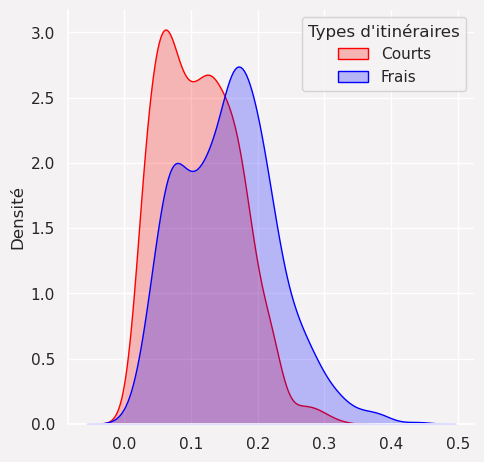

{'IF':        mean       var  quantiles
 0  0.155509  0.005198       0.10
 1  0.155509  0.005198       0.16
 2  0.155509  0.005198       0.20,
 'LEN':        mean       var  quantiles
 0  0.112479  0.003476       0.06
 1  0.112479  0.003476       0.11
 2  0.112479  0.003476       0.16}

In [24]:
basic_stats_key("P10O0_01At0_01Ar0_01C0_01E0_01Ca0_01", "mean_prairies_prop", hour="13h", distinct_if_len=True)

In [226]:
ks_2samp_test_key("P10O0_01At0_01Ar0_01C0_01E0_01Ca0_01", "mean_prairies_prop", hour="13h")

KS statistics :  0.2650306748466258
p-value :  1.4301772935676865e-25


(0.2650306748466258, 1.4301772935676865e-25)

In [227]:
d_cohen_key("P10O0_01At0_01Ar0_01C0_01E0_01Ca0_01", "mean_prairies_prop", hour="13h")

-0.6527720318744223

In [228]:
gain_prairies = gain_compare_key("P10O0_01At0_01Ar0_01C0_01E0_01Ca0_01", "mean_prairies_prop", hour="13h")

Gain quantiles :  [ 0.   25.   69.23]
Gain mean :  59.48499386503068


In [230]:
for w in range(9,3, -2):
    print("POID PRAIRIES : ", w)
    print("Arbres")
    ks_2samp_test_key(f"P{w}O5At0_01Ar10C0_01E5Ca0_01", "mean_arbres_prop", hour="13h")
    # print("student : ", test_students_key(f"P0_01O{w}At0_01Ar10C0_01E0_01Ca0_01", "mean_arbres_prop"))
    # print("wilcoxon :", wilcoxon_test_key(f"P0_01O{w}At0_01Ar10C0_01E0_01Ca0_01", "mean_arbres_prop"))
    print("d cohen: ", d_cohen_key(f"P{w}O5At0_01Ar10C0_01E5Ca0_01", "mean_arbres_prop", hour="13h"))
    gain__arbres = gain_compare_key(f"P{w}O5At0_01Ar10C0_01E5Ca0_01", "mean_arbres_prop", hour="13h")
    # sns_plot_key(f"P0_01O{w}At0_01Ar10C0_01E0_01Ca0_01", "mean_arbres_prop")
    print("PRAIRIES")
    gain__ombres = gain_compare_key(f"P{w}O5At0_01Ar10C0_01E5Ca0_01", "mean_arbustes_prop", hour="13h")
    ks_2samp_test_key(f"P{w}O5At0_01Ar10C0_01E5Ca0_01", "mean_arbustes_prop", hour="13h")
    # print("student : ", test_students_key(f"P0_01O{w}At0_01Ar10C0_01E0_01Ca0_01", "mean_ombres_13_prop"))
    # print("wilcoxon :", wilcoxon_test_key(f"P0_01O{w}At0_01Ar10C0_01E0_01Ca0_01", "mean_ombres_13_prop"))
    print("d cohen: ", d_cohen_key(f"P{w}O5At0_01Ar10C0_01E5Ca0_01", "mean_arbustes_prop", hour="13h"))
    # sns_plot_key(f"P0_01O{w}At0_01Ar10C0_01E0_01Ca0_01", "mean_ombres_13_prop")
    print("#### ####")

POID PRAIRIES :  9
Arbres
KS statistics :  0.19631901840490798
p-value :  3.792377243339718e-14
d cohen:  -0.42805953872428126
Gain quantiles :  [ 0.     7.69  42.365]
Gain mean :  37.496564417177915
PRAIRIES
Gain quantiles :  [ 0.    0.   16.67]
Gain mean :  9834.72117791411
KS statistics :  0.05889570552147239
p-value :  0.11836880718540357
d cohen:  -0.06582972477449278
#### ####
POID PRAIRIES :  7
Arbres
KS statistics :  0.19754601226993865
p-value :  2.5450892360527816e-14
d cohen:  -0.4501139224514738
Gain quantiles :  [ 0.     9.09  44.915]
Gain mean :  39.96277300613497
PRAIRIES
Gain quantiles :  [ 0.    0.   16.67]
Gain mean :  9834.61672392638
KS statistics :  0.053987730061349694
p-value :  0.18585231421882395
d cohen:  -0.06342657721675099
#### ####
POID PRAIRIES :  5
Arbres
KS statistics :  0.20368098159509201
p-value :  3.334453699101983e-15
d cohen:  -0.4733194948260538
Gain quantiles :  [ 0.   11.11 50.  ]
Gain mean :  41.839141104294484
PRAIRIES
Gain quantiles :  [ 0. 

## Analyse de la pondération mise en production en juillet : 

Prairies : 1, Arbustes : 1, Ombre 8, Arbres: 10, Température 6, Eau 7 et Parcs 8

In [232]:
def calculate_mean_score(it, score_column):
    """Calculate the mean score for a given itinerary"""
    # print(score_column)
    # print(it[score_column])
    return round(sum(it[score_column])/sum(it["length"]), 2)

def create_df_mean_value_by_columns(itineraries_path, edges_path, output_path, columns, total_score_column, max_score):
    """Calculate the mean proportion or score by itineraries"""

    edges_it = gpd.read_file(itineraries_path)
    edges = gpd.read_file(edges_path)
    edges_it = edges_it.set_index(["uniqId"])
    edges = edges.set_index(["uniqId"])

    edges_sample = edges.loc[edges_it.index.to_list()]

    edges_it[columns] = edges_sample[columns]
    it_grouped = edges_it.groupby(["id_it", "type"], axis=0)
    itineraries =  pd.DataFrame({})
    for column in columns: 
        itineraries[f"mean_{column}"] = it_grouped.apply(lambda x: calculate_mean_prop(x, column))

    itineraries["total_length"] = it_grouped.apply(lambda x: round(sum(x["length"]), 2))
    itineraries["mean_score"] = it_grouped.apply(lambda x: calculate_mean_score(x, total_score_column))
    itineraries["score_10"] = convert_score_on_ten(itineraries["mean_score"], max_score)

    itineraries.to_csv(output_path)

In [233]:
columns = ["prairies_prop", "arbustes_prop", "arbres_prop", "C_wavg_scaled", "eaux_prop", "canop", "ombres_08_prop", "ombres_13_prop", "ombres_18_prop"]
total_score_column = "score_distance_13"
global_gdf = gpd.read_file(f"output_data/analyse/P1O8At2Ar10C6E7Ca8_test/dataset_P1O8At2Ar10C6E7Ca8_test.gpkg")
max_score = np.max(global_gdf[total_score_column])
create_df_mean_value_by_columns(f"output_data/analyse/P1O8At2Ar10C6E7Ca8_test/dataset_P1O8At2Ar10C6E7Ca8_test.gpkg", "output_data/analyse/edges_all_prop.gpkg", f"output_data/analyse/P1O8At2Ar10C6E7Ca8_test/mean_value_by_itP1O8At2Ar10C6E7Ca8_test.csv", columns, total_score_column, max_score)

### mean_prairies_prop #### 


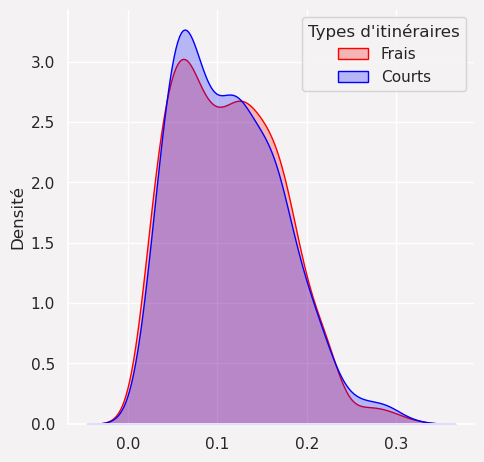

KS statistics :  0.020858895705521473
p-value :  0.9943951304772092
Gain quantiles :  [0.   0.   7.14]
Gain mean :  5.506834355828221
### mean_arbustes_prop #### 


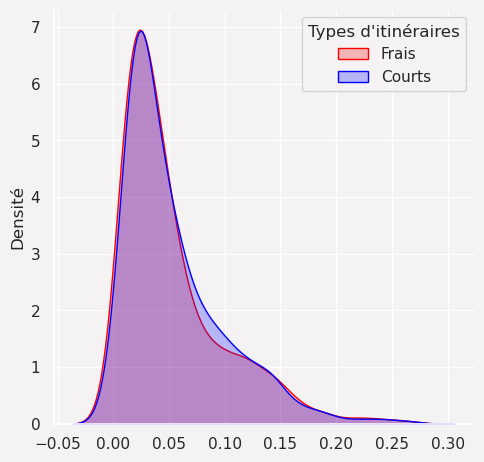

KS statistics :  0.044171779141104296
p-value :  0.40452332601436647
Gain quantiles :  [0. 0. 0.]
Gain mean :  6147.472552147239
### mean_arbres_prop #### 


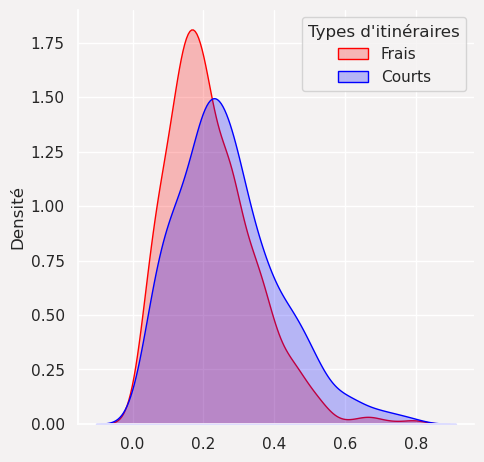

KS statistics :  0.16932515337423312
p-value :  1.2887937942669167e-10
Gain quantiles :  [ 0.    6.25 33.33]
Gain mean :  30.581730061349695
### mean_C_wavg_scaled #### 


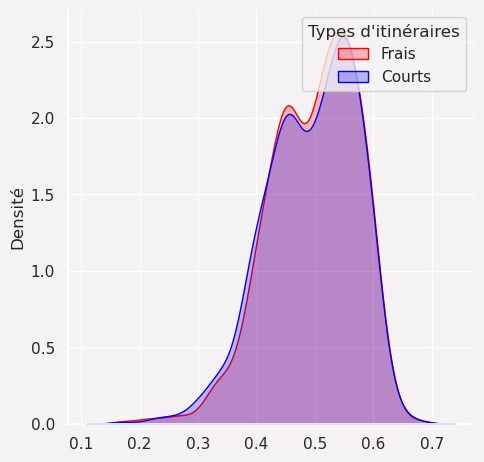

KS statistics :  0.025766871165644172
p-value :  0.9497858120258376
Gain quantiles :  [0. 0. 0.]
Gain mean :  -0.6602331288343559
### mean_eaux_prop #### 


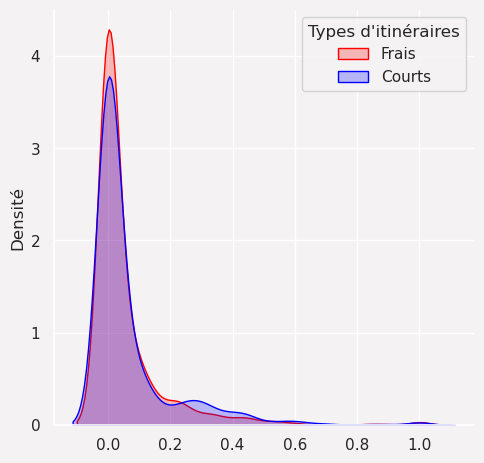

KS statistics :  0.04539877300613497
p-value :  0.37060604882127646
Gain quantiles :  [0. 0. 0.]
Gain mean :  265041.6552392638
### mean_canop #### 


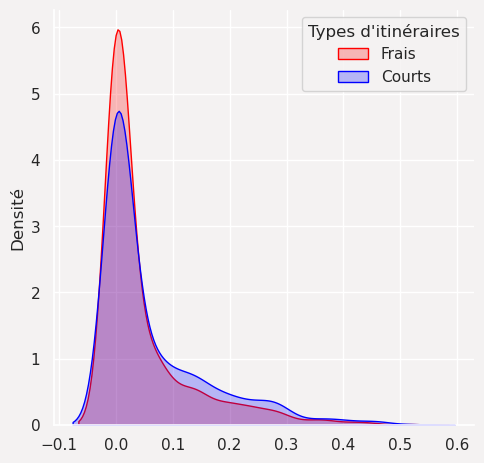

KS statistics :  0.08466257668711656
p-value :  0.005787967546023952
Gain quantiles :  [0. 0. 0.]
Gain mean :  634380.7210920246
### mean_ombres_13_prop #### 


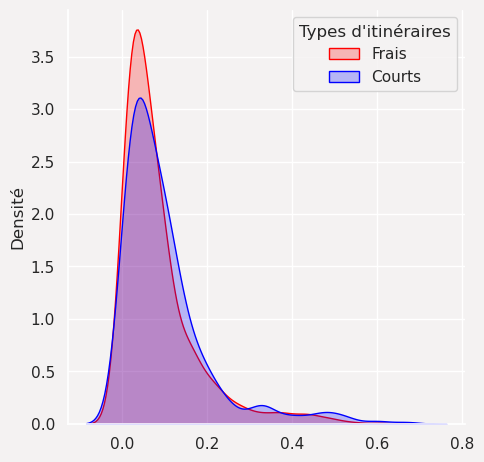

KS statistics :  0.08588957055214724
p-value :  0.004878896980998564
Gain quantiles :  [ 0.     0.    28.285]
Gain mean :  50341.02321472393


In [236]:
features = ["mean_prairies_prop", "mean_arbustes_prop", "mean_arbres_prop", "mean_C_wavg_scaled", "mean_eaux_prop", "mean_canop", "mean_ombres_13_prop"]
for column in features:
    print(f"### {column} #### ")
    basic_stats_key("P1O8At2Ar10C6E7Ca8_test", column, hour=False, distinct_if_len=True)
    ks_2samp_test_key("P1O8At2Ar10C6E7Ca8_test", column, hour=False)
    d_cohen_key("P1O8At2Ar10C6E7Ca8_test", column, hour=False)
    gain_compare_key("P1O8At2Ar10C6E7Ca8_test", column, hour=False)